## Komodo Energy Coding Challenge

In [5]:
# Find out what versions of packages I have installed in my venv
#pip list

In [333]:
import numpy as np #numpy==1.24.3
import pandas as pd #pandas==2.0.3
import matplotlib.pyplot as plt #matplotlib==3.7.2
import sklearn as sl #sklearn == 1.3.0
import datetime as dt

# Data Exploration

## Household usage

In [9]:
# Read in the household usage data
energy = pd.read_csv('household_usage.csv')
energy = energy[['Time', 'Standard_Household', 'HeatPump_Household', 'HeatPump_Battery_Household']]
energy

,Time,Standard_Household,HeatPump_Household,HeatPump_Battery_Household
0,00:00,0.4,0.6,0.6
1,00:30,0.3,0.5,0.5
2,01:00,0.3,0.5,0.5
3,01:30,0.3,0.5,0.5
4,02:00,0.2,0.4,0.5
5,02:30,0.2,0.4,5.0
6,03:00,0.2,0.4,5.0
7,03:30,0.2,0.4,5.0
8,04:00,0.2,0.4,0.0
9,04:30,0.2,0.4,0.0


<Axes: xlabel='Time', ylabel='kWh'>

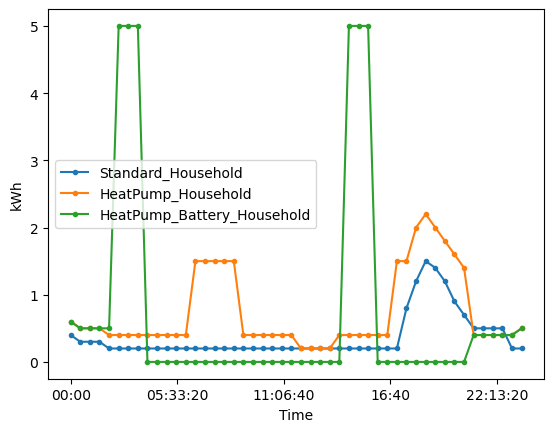

In [523]:
# Plot
energy.set_index('Time').plot(style='.-', ylabel='kWh')


In [11]:
# Get some useful stats
energy.set_index('Time').describe()

,Standard_Household,HeatPump_Household,HeatPump_Battery_Household
count,48.000000,48.000000,48.000000
mean,0.366667,0.735417,0.731250
std,0.336650,0.584731,1.642152
min,0.200000,0.200000,0.000000
25%,0.200000,0.400000,0.000000
50%,0.200000,0.400000,0.000000
75%,0.325000,1.425000,0.425000
max,1.500000,2.200000,5.000000


In [12]:
# Find the time when the energy consumption is the max
e = energy.set_index('Time')
e[e==e.max()].dropna(how='all')

,Standard_Household,HeatPump_Household,HeatPump_Battery_Household
Time,,,
02:30,NaN,NaN,5.0
03:00,NaN,NaN,5.0
03:30,NaN,NaN,5.0
14:30,NaN,NaN,5.0
15:00,NaN,NaN,5.0
15:30,NaN,NaN,5.0
18:30,1.5,2.2,NaN


In [13]:
# Find the time when the energy consumption is the minimum
energy.set_index('Time').idxmin()


Standard_Household            02:00
HeatPump_Household            12:00
HeatPump_Battery_Household    04:00
dtype: object

In [14]:
# Find the daily energy usage
energy.set_index('Time').sum()


Standard_Household            17.6
HeatPump_Household            35.3
HeatPump_Battery_Household    35.1
dtype: float64

### How do different households use energy at different times of day?

The standard household represents a typical UK home where the consumption is mainly in the evening.
The household are likely out during the day at work and return at 5.30pm.
There is a base load of 0.2kWh and a peak load of 1.5kWh at 18:30-19:00.

The Heat pump household has large peaks in the morning and the evening.
This is presumably when the heating/hot water are on. The maximum energy use was 2.2kWh.
The total consumption is approximately double the standard household at 35 kWh per day.

The Heat Pump battery household has a similar total consuption to the heat pump household but the times of usage are different. This suggests that we're modelling a battery that is 100% efficient. That is, all the energy that goes into the battery is available for the home to use.
The battery is charged overight and early afternoon (2.30-4pm), presumably when the tariff is cheaper. I've shown in the Tariff section that this is the case.
Home usage is zero from 4am until 20:30 when the charge in the battery runs out. 
The battery charges for 90 mins at 5kWh per 30 mins. So this is probably a ~12-15kWh battery. We could do the full calculation by subtracting the heat pump only usage and suming the remaining energy used between battery charge times. In reality you would expect a battery system to use more due to inverter losses.

No missing data or outliers seen. Data is for a single day.

## Tariff

In [290]:
# Read in tariff data
tariff = pd.read_json('agile_price_example.json')
tariff


,count,next,previous,results
0,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 20.95, 'value_inc_vat': 21.9..."
1,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 21.34, 'value_inc_vat': 22.4..."
2,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 24.8, 'value_inc_vat': 26.04..."
3,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 26.68, 'value_inc_vat': 28.0..."
4,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 26.5, 'value_inc_vat': 27.82..."
...,...,...,...,...
91,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 22.26, 'value_inc_vat': 23.3..."
92,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 20.7, 'value_inc_vat': 21.73..."
93,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 19.56, 'value_inc_vat': 20.5..."
94,51744,https://api.octopus.energy/v1/products/AGILE-2...,NaN,"{'value_exc_vat': 20.56, 'value_inc_vat': 21.5..."


In [292]:
# Extract the datetime and prices that include VAT
valid_from = [x['valid_from'] for x in tariff['results']]
valid_from = pd.to_datetime(pd.Series(valid_from))
value_inc_vat = [x['value_inc_vat'] for x in tariff['results']]
prices = pd.DataFrame(value_inc_vat, index=valid_from).sort_index()
prices.columns=['tariff']
prices

,tariff
2025-03-11 23:00:00+00:00,20.4120
2025-03-11 23:30:00+00:00,21.5880
2025-03-12 00:00:00+00:00,20.5380
2025-03-12 00:30:00+00:00,21.7350
2025-03-12 01:00:00+00:00,23.3730
...,...
2025-03-13 20:30:00+00:00,27.8250
2025-03-13 21:00:00+00:00,28.0140
2025-03-13 21:30:00+00:00,26.0400
2025-03-13 22:00:00+00:00,22.4070


In [294]:
prices.describe()

,tariff
count,96.000000
mean,25.921109
std,7.228227
min,18.595500
25%,21.110250
50%,23.425500
75%,27.604500
max,48.363000


<Axes: ylabel='p/kWh'>

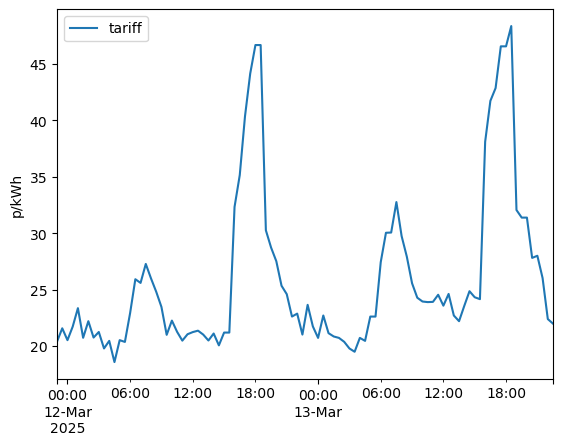

In [527]:
prices.plot(ylabel='p/kWh')

We have data from Tues 11/3/25 23:00 to Thu 13/3/25 23:00. So 48 hours but not quite 2 full days. The pattern in the two days is similar but slightly different. There's a peak in the morning and a larger peak in the evening around 6pm when people use most energy. 

date
2025-03-11    Axes(0.125,0.11;0.775x0.77)
2025-03-12    Axes(0.125,0.11;0.775x0.77)
2025-03-13    Axes(0.125,0.11;0.775x0.77)
Name: tariff, dtype: object

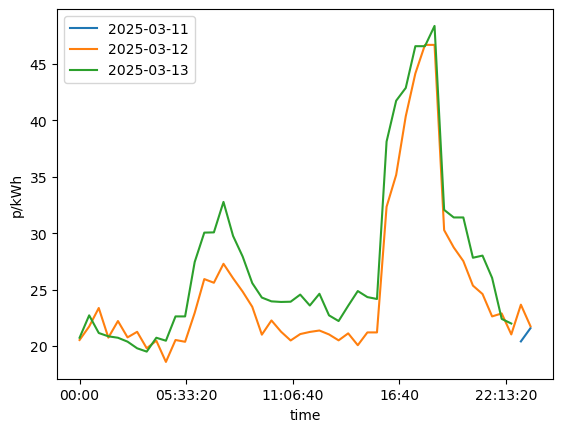

In [533]:
# Overplot the data 
prices['date']=prices.index.date
prices['time']=prices.index.time
prices.set_index('time').groupby(['date'])['tariff'].plot(legend=True, ylabel='p/kWh')

The amplitude slightly differs between the two days, particularly the morning peak and the afternoon baseline. Peak price is around 48p/kWh and minimum price is around 19p/kWh on both days. NB These are both weekdays


In [594]:
# Show the times when the battery charges. Discussed below instead
#prices.set_index('time').groupby(['date'])['tariff'].plot(legend=True, ylabel='p/kWh')
#plt.axvline(dt.time(2,30,0), color='black', linestyle='--')
#plt.axvline(dt.time(3,30,0), color='black', linestyle='--')
#plt.axvline(dt.time(14,30,0), color='black', linestyle='--')
#plt.axvline(dt.time(15,30,0), color='black', linestyle='--')

No missing data or outliers seen. 


## Flexibility Event

In [272]:
# Read in flexibilty data
flex = pd.read_json('flexibility_opportunity.json')
flex

,flexibility_opportunities
0,"{'event_type': 'demand_turn_down', 'start_time..."
1,"{'event_type': 'demand_turn_up', 'start_time':..."


In [274]:
flex = pd.json_normalize(flex['flexibility_opportunities'])
flex

,event_type,start_time,end_time,price_per_kWh,min_flexibility_kWh,max_flexibility_kWh
0,demand_turn_down,18:00,19:30,1.5,1.0,5.0
1,demand_turn_up,02:00,04:00,0.5,0.5,3.0


In [282]:
# Calculate the maximum return from each event
flex['price_per_kWh']*flex['max_flexibility_kWh']

0    7.5
1    1.5
dtype: float64

There are two events specified - a turn down (reduce consumption) and a turn up (use excess grid energy). Turn down is more lucrative and could earn £7.50 if the maximum energy is saved (5kWh). If you could combine the two, i.e. move your energy use from the turn down time to the turn up time, a householder could earn £9. 

The minimum flexibility for a turn down event is 1 kWh, so just shifting appliances like washing machine/oven/tumble dryer may be enough to earn a little. However, hot water and space heating are more reliably shifted with less disruption to the householder as they can be controlled automatically and have larger capacity for shifting energy. 

## Load shifting potential

In [688]:
# Merge the datasets
energy['time'] = pd.to_datetime(flex_energy['Time'], format= '%H:%M:%S').dt.time
p=prices.groupby(['date', 'time']).max().unstack(level=0).droplevel(level=0, axis=1)
flex_pot = pd.merge(energy, p, on="time")
flex_pot.columns=['Time', 'Standard_Household', 'HeatPump_Household', 'HeatPump_Battery_Household', 'time','2025-03-11', '2025-03-12', '2025-03-13']

(10.0, 60.0)

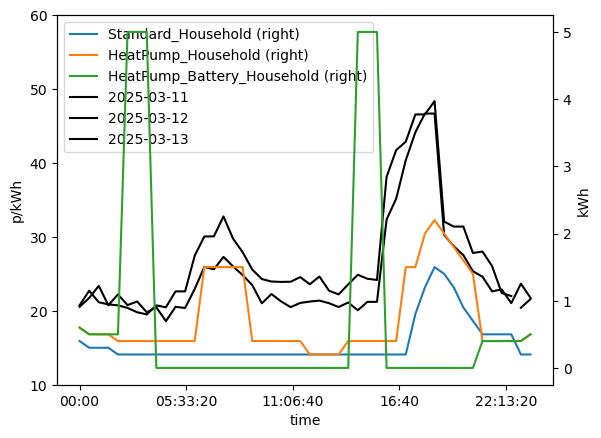

In [692]:
# Plot the tariff and energy use
ax = flex_pot.set_index('time').plot(ylabel='kWh', color=['C0', 'C1', 'C2', 'black', 'black', 'black'], secondary_y=['Standard_Household', 'HeatPump_Household', 'HeatPump_Battery_Household'])
ax.set_ylabel('p/kWh')
ax.set_ylim(10,60)



The plot above shows the potential for saving through load shifting.
As we expected, the times when the battery charges are when the tariff is low, and just before the evening peak. This will help the battery last as long as possible over the most expensive time.
When the price is most expensive, in the evening, both the Standard and Heat pump households have their highest consumption. 
They could save money by shifting away from this time. The heat pump household has a higher consumption so more to gain.
The heat pump household also uses a lot of energy during the morning peak. Therefore the heatpump household has the most to gain from load shifting.

In [619]:
flex_pot.head()

,Time,Standard_Household,HeatPump_Household,HeatPump_Battery_Household,time,2025-03-11,2025-03-12,2025-03-13
0,00:00:00,0.4,0.6,0.6,00:00:00,NaN,20.538,20.7375
1,00:30:00,0.3,0.5,0.5,00:30:00,NaN,21.735,22.7220
2,01:00:00,0.3,0.5,0.5,01:00:00,NaN,23.373,21.1575
3,01:30:00,0.3,0.5,0.5,01:30:00,NaN,20.748,20.8635
4,02:00:00,0.2,0.4,0.5,02:00:00,NaN,22.218,20.7375


### Cost

In [862]:
# Calculate the cost in £ assuming the usage data is from 13/3/2025
flex_pot['SH_ag_cost'] = flex_pot['Standard_Household']*flex_pot['2025-03-12']/100
flex_pot['HP_ag_cost'] = flex_pot['HeatPump_Household']*flex_pot['2025-03-12']/100
flex_pot['HPB_ag_cost'] = flex_pot['HeatPump_Battery_Household']*flex_pot['2025-03-12']/100
# Current Ofgem price cap (1 April to 30 June 2025 )
flat_tariff = 27.03
flex_pot['SH_ft_cost'] = flex_pot['Standard_Household']*flat_tariff/100
flex_pot['HP_ft_cost'] = flex_pot['HeatPump_Household']*flat_tariff/100
flex_pot['HPB_ft_cost'] = flex_pot['HeatPump_Battery_Household']*flat_tariff/100

flex_pot.head()

,Time,Standard_Household,HeatPump_Household,HeatPump_Battery_Household,time,2025-03-11,2025-03-12,2025-03-13,SH_ag_cost,HP_ag_cost,HPB_ag_cost,SH_ft_cost,HP_ft_cost,HPB_ft_cost
0,00:00:00,0.4,0.6,0.6,00:00:00,NaN,20.538,20.7375,0.082152,0.123228,0.123228,0.10812,0.16218,0.16218
1,00:30:00,0.3,0.5,0.5,00:30:00,NaN,21.735,22.7220,0.065205,0.108675,0.108675,0.08109,0.13515,0.13515
2,01:00:00,0.3,0.5,0.5,01:00:00,NaN,23.373,21.1575,0.070119,0.116865,0.116865,0.08109,0.13515,0.13515
3,01:30:00,0.3,0.5,0.5,01:30:00,NaN,20.748,20.8635,0.062244,0.103740,0.103740,0.08109,0.13515,0.13515
4,02:00:00,0.2,0.4,0.5,02:00:00,NaN,22.218,20.7375,0.044436,0.088872,0.111090,0.05406,0.10812,0.13515


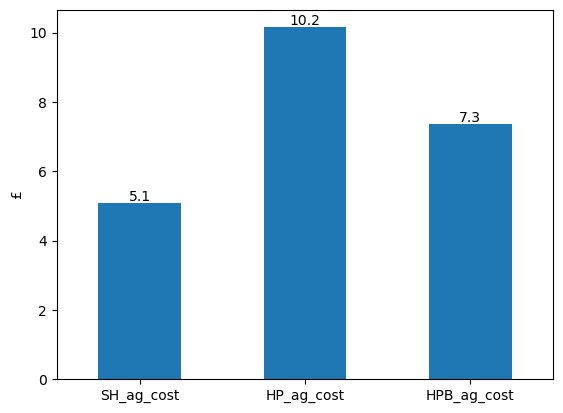

In [864]:
# Plot the daily cost for each household under agile tariff
ax = flex_pot[['SH_ag_cost','HP_ag_cost','HPB_ag_cost']].sum().plot.bar(ylabel='£')
plt.xticks(rotation=0)
for c in ax.containers: ax.bar_label(c, fmt='%.1f', label_type='edge')


The plot shows that a heat pump home could save around £3 per day from using a battery to shift the load from peak to off peak times under the agile tariff.

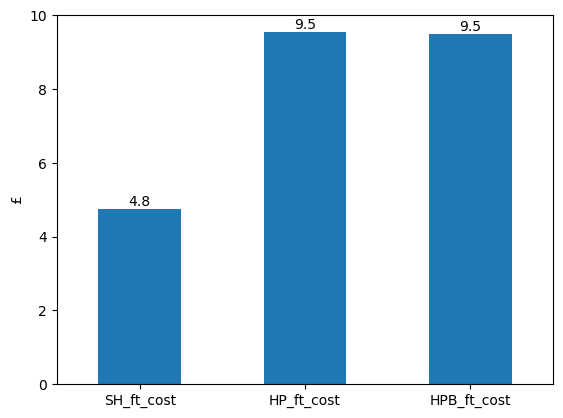

In [866]:
# Plot the daily cost for each household under agile tariff
ax = flex_pot[['SH_ft_cost','HP_ft_cost','HPB_ft_cost']].sum().plot.bar(ylabel='£')
plt.xticks(rotation=0)
for c in ax.containers: ax.bar_label(c, fmt='%.1f', label_type='edge')

The standard and heat pump homes would pay slightly less under the flat tariff. The heat pump homes with and without the battery have the same cost under the flat tariff. A heat pump home with a battery moving from a flat tariff to an agile one would save about £2 per day.

### Flexibility Provider

A flexibility provider could make the following conclusions based on this data:
* Battery systems are already likely to be optimised for the low demand times. But they could be very useful for turn-up events. They may be able to react more quickly and have more capacity for energy storage.
* Heat pumps offer the most turn-down potential, as they could shift their heating/hot water earlier particularly at the 6-7.30 time, if there is enough warning. They have the capacity to turn down more than the standard households. 
* Heat pump homes and standard homes with hot water tanks also have the potential for turn-up events as they could store some energy in the tank.


# Recomending when to shift energy use 

In [ ]:
# max of 6 kWh per half hour
# 0.5kWh per half hour
# cost increases: night time, away during day, far from desired time
# max number of appliances can shift
# minimum price gain
# gain money from turndown



In [1804]:
def sim_trial_schedule(schedule_start_time, trial_start_time, duration, power):

    schedule = create_schedule(schedule_start_time, duration)
    trial_schedule = create_schedule(trial_start_time, duration)
    
    opt = pd.DataFrame(flex_pot['time']).reset_index()
    opt['tariff'] = flex_pot['2025-03-12']
    
    opt['schedule'] =  opt['time'].apply(lambda x: 1 if x in schedule else 0)
    opt['schedule_load_cost'] = opt['schedule']* power/2 * opt['tariff']
    
    opt['trial_schedule'] = opt['time'].apply(lambda x: 1 if x in trial_schedule else 0)
    opt['trial_load_cost'] = opt['trial_schedule']* power/2 * opt['tariff']
    
    opt['night'] = opt['time'].apply(lambda x: 1 if x < dt.time(6,0) else 1 if x > dt.time(23,0) else 0) # only works if schedule is during day
    opt['night_cost'] = opt['night'] * opt['trial_schedule'] * 50
    
    start_time_index = opt[opt['time']==schedule_start_time].index.item()
    opt['inconvenient'] = opt['index'].apply(lambda x: (start_time_index-x) if x < start_time_index else (x-start_time_index-duration*2+1)*2 if x >= start_time_index+duration*2 else 0)
    opt['inconvenient_cost'] = opt['trial_schedule'] * opt['inconvenient']
    
    opt['total_cost'] = opt['trial_load_cost'] + opt['night_cost'] + opt['inconvenient_cost']

    cost = opt['total_cost'].sum()
    true_cost = opt['trial_load_cost'].sum()
    
    return opt, cost, true_cost

In [1806]:
def create_schedule(schedule_start_time, duration):
    schedule = []
    schedule_start_date = dt.datetime.combine(dt.date.today(), schedule_start_time)
    for hh in range(duration*2):
        schedule_time = (schedule_start_date + dt.timedelta(minutes=30*hh)).time()
        schedule.append(schedule_time) 

    return schedule
    

In [1962]:

schedule_start_time = dt.time(20,0,0)
duration = 2 #hours   #doesn't work for 0.5 hour
power = 2 #kW

trial_cost=[]
true_trial_cost=[]
trial_start_times = pd.date_range(dt.datetime(2000,1,1,0,0,0),periods=48-duration*2+1,freq='30min')

# Put into an optimiser instead of a loop?
for trial_start_time in trial_start_times:
    opt, cost, true_cost = sim_trial_schedule(schedule_start_time, trial_start_time.time(), duration, power)
    trial_cost.append(cost)
    true_trial_cost.append(true_cost)


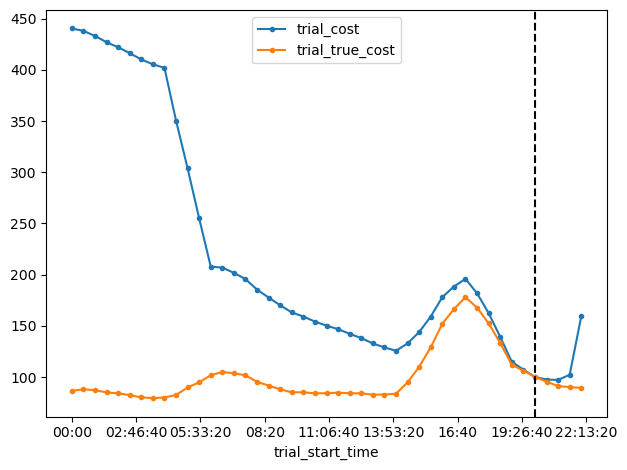

In [1963]:
results=pd.DataFrame(trial_start_times.time, trial_cost).reset_index()
results.columns=['trial_cost','trial_start_time']
results['trial_start_time'] = results['trial_start_time']
results['trial_true_cost'] = true_trial_cost
results.plot('trial_start_time', ['trial_cost', 'trial_true_cost'], style='.-')
plt.axvline(schedule_start_time, color='black', linestyle='--')
plt.tight_layout()

In [1966]:
optimum_time = results[results['trial_cost']==results['trial_cost'].min()]['trial_start_time'].item()
opt, cost, true_cost = sim_trial_schedule(schedule_start_time, optimum_time, duration, power)
cost_saving = (opt['schedule_load_cost']-opt['trial_load_cost']).sum()
total_saving = (opt['schedule_load_cost']-opt['total_cost']).sum()
print(schedule_start_time, optimum_time, cost_saving, total_saving)

if (total_saving > 0) & (cost_saving > 10):
    print('You would save £%s by switching your schedule from %s to %s' % (round(cost_saving)/100, schedule_start_time, optimum_time))
else:
    print('It is not worth switching your schedule today')

20:00:00 21:00:00 8.966999999999999 2.9669999999999987
It is not worth switching your schedule today


In [1942]:
opt

,index,time,tariff,schedule,schedule_load_cost,trial_schedule,trial_load_cost,night,night_cost,inconvenient,inconvenient_cost,total_cost
0,0,00:00:00,20.5380,0,0.0000,0,0.0000,1,0,18,0,0.0000
1,1,00:30:00,21.7350,0,0.0000,0,0.0000,1,0,17,0,0.0000
2,2,01:00:00,23.3730,0,0.0000,0,0.0000,1,0,16,0,0.0000
3,3,01:30:00,20.7480,0,0.0000,0,0.0000,1,0,15,0,0.0000
4,4,02:00:00,22.2180,0,0.0000,0,0.0000,1,0,14,0,0.0000
5,5,02:30:00,20.7690,0,0.0000,0,0.0000,1,0,13,0,0.0000
6,6,03:00:00,21.2625,0,0.0000,0,0.0000,1,0,12,0,0.0000
7,7,03:30:00,19.8030,0,0.0000,0,0.0000,1,0,11,0,0.0000
8,8,04:00:00,20.4750,0,0.0000,0,0.0000,1,0,10,0,0.0000
9,9,04:30:00,18.5955,0,0.0000,0,0.0000,1,0,9,0,0.0000
